**Ridge Regression Machine Learning model**
### Methodology
1. **Load Data**: Batting, Master, Salaries, Teams tables.
2. **Preprocess**: Calculate Age, filter for 1999-2015 era.
3. **Feature Engineering**:
   - **OPS**: On-base Plus Slugging.
   - **Relative OPS**: Adjusted for league offensive environment.
   - **Aging Curve**: Age and Age².
   - **Context**: Salary, Strikeout Rate, Walk Rate.
4. **Modeling**: Train predict Next Year OPS.
5. **Analysis**: Identify top underperformers/overperformers.

In [97]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

DATA_DIR = os.path.expanduser('~/Downloads/Capstone Hitters MLB')
MIN_AB = 300
START_YEAR = 1999
END_YEAR = 2015

In [98]:
def load_data(data_dir):
    try:
        batting = pd.read_csv(os.path.join(data_dir, 'Batting.csv'))
        master_path = os.path.join(data_dir, 'Master.csv')
        if not os.path.exists(master_path):
             master_path = os.path.join(data_dir, 'MAster.csv')
        master = pd.read_csv(master_path)
        salaries = pd.read_csv(os.path.join(data_dir, 'Salaries.csv'))
        teams = pd.read_csv(os.path.join(data_dir, 'Teams.csv'))
        print("Data Loaded Successfully.")
        return batting, master, salaries, teams
    except FileNotFoundError as e:
        print(f"Error loading data: {e}")
        return None, None, None, None

batting, master, salaries, teams = load_data(DATA_DIR)

Data Loaded Successfully.


- Calculate **Age**
- Calculate **OPS** and **Relative OPS** vs League Average

In [99]:
df = df.sort_values(['playerID', 'yearID'])
df['Prev_Year_OPS'] = df.groupby('playerID')['OPS'].shift(1)

df['OPS_Trend'] = df['OPS'] - df['Prev_Year_OPS']

df['OPS_Trend'] = df['OPS_Trend'].fillna(0)

In [100]:
def preprocess_and_engineer(batting, master, teams, salaries, start_year, end_year):
    df = pd.merge(batting, master[['playerID', 'birthYear']], on='playerID', how='inner')
    df = df[(df['yearID'] >= start_year) & (df['yearID'] <= end_year)].copy()
    df['Age'] = df['yearID'] - df['birthYear']

    for col in ['H', 'BB', 'HBP', 'AB', 'SF', '2B', '3B', 'HR', 'SO']:
        if col in df.columns:
             df[col] = df[col].fillna(0)
    df = df[df['AB'] >= MIN_AB].copy()

    obp_denom = df['AB'] + df['BB'] + df['HBP'] + df['SF']
    df['OBP'] = (df['H'] + df['BB'] + df['HBP']) / obp_denom
    df['TB'] = df['H'] + 2*df['2B'] + 3*df['3B'] + 4*df['HR']
    df['SLG'] = df['TB'] / df['AB']
    df['OPS'] = df['OBP'] + df['SLG']

    league_stats = teams.groupby('yearID').agg({
        'H': 'sum', 'BB': 'sum', 'HBP': 'sum', 'AB': 'sum',
        'SF': 'sum', '2B': 'sum', '3B': 'sum', 'HR': 'sum'
    }).reset_index()
    league_stats['L_OBP'] = (league_stats['H'] + league_stats['BB'] + league_stats['HBP']) / (league_stats['AB'] + league_stats['BB'] + league_stats['HBP'] + league_stats['SF'])
    league_stats['L_SLG'] = (league_stats['H'] + 2*league_stats['2B'] + 3*league_stats['3B'] + 4*league_stats['HR']) / league_stats['AB']
    league_stats['League_OPS'] = league_stats['L_OBP'] + league_stats['L_SLG']

    df = pd.merge(df, league_stats[['yearID', 'League_OPS']], on='yearID', how='left')
    df['Relative_OPS'] = df['OPS'] - df['League_OPS']

    df['SO_Rate'] = df['SO'] / df['AB']
    df['BB_Rate'] = df['BB'] / df['AB']
    df['Age_Squared'] = df['Age'] ** 2

    if not salaries.empty:
        df = pd.merge(df, salaries[['playerID', 'yearID', 'salary']], on=['playerID', 'yearID'], how='left')
        df['salary'] = df.groupby('yearID')['salary'].transform(lambda x: x.fillna(x.median()))
        df['salary'] = df['salary'].fillna(df['salary'].median())
    else:
        df['salary'] = 0

    df = df.sort_values(['playerID', 'yearID'])
    df['Next_Year_OPS'] = df.groupby('playerID')['OPS'].shift(-1)

    return df.dropna(subset=['Next_Year_OPS'])

df = preprocess_and_engineer(batting, master, teams, salaries, START_YEAR, END_YEAR)
print(f"data prep is done. {len(df)} player-records are prepped.")
df.head()

data prep is done. 3154 player-records are prepped.


,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,TB,SLG,OPS,League_OPS,Relative_OPS,SO_Rate,BB_Rate,Age_Squared,salary,Next_Year_OPS
469,abernbr01,2001,1,TBA,AL,79,304.0,43.0,82.0,17.0,...,139.0,0.457237,0.785550,0.850273,-0.064723,0.115132,0.088816,576.0,3000000.0,0.651157
0,abreubo01,1999,1,PHI,NL,152,546.0,118.0,183.0,35.0,...,366.0,0.670330,1.115949,0.866463,0.249486,0.206960,0.199634,625.0,400000.0,1.103676
242,abreubo01,2000,1,PHI,NL,154,576.0,103.0,182.0,42.0,...,396.0,0.687500,1.103676,0.874990,0.228687,0.201389,0.173611,676.0,2933333.0,1.077139
470,abreubo01,2001,1,PHI,NL,162,588.0,118.0,170.0,48.0,...,402.0,0.683673,1.077139,0.850273,0.226866,0.232993,0.180272,729.0,4983000.0,1.066985
707,abreubo01,2002,1,PHI,NL,157,572.0,102.0,176.0,50.0,...,374.0,0.653846,1.066985,0.836520,0.230465,0.204545,0.181818,784.0,6333333.0,0.973624


Train Model: Ridge Regression
Ridge Regression is used to prevent overfitting. 
Features: `Age`, `Age_Squared`, `SO_Rate`, `BB_Rate`, `Relative_OPS`, `salary`.

In [101]:
target = 'Next_Year_OPS'

df = df.sort_values(['playerID', 'yearID'])
df['Prev_Year_OPS'] = df.groupby('playerID')['OPS'].shift(1)
df['OPS_Trend'] = df['OPS'] - df['Prev_Year_OPS']
df['OPS_Trend'] = df['OPS_Trend'].fillna(0) 

features = ['Age', 'Age_Squared', 'SO_Rate', 'BB_Rate', 'Relative_OPS', 'salary', 'OPS_Trend']

model_data = df.dropna(subset=features + [target]).copy()
print(f"Data Prep Complete: {len(model_data)} records ready for modeling.")

Data Prep Complete: 3154 records ready for modeling.


In [127]:
X = model_data[features]
y = model_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data successfully split and scaled.")

Data successfully split and scaled.


In [130]:
ridge_model = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0])
dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

ridge_model.fit(X_train_scaled, y_train)
dt_model.fit(X_train_scaled, y_train)
rf_model.fit(X_train_scaled, y_train)

results = {
    "Ridge Regression": y_pred_ridge,
    "Decision Tree": dt_model.predict(X_test_scaled),
    "Random Forest": rf_model.predict(X_test_scaled)
}

print(f"{'Model Comparison':<20} | {'MAE':<10} | {'R2 Score':<10}")
print("-" * 50)
for name, preds in results.items():
    m_mae = mean_absolute_error(y_test, preds)
    m_r2 = r2_score(y_test, preds)
    print(f"{name:<20} | {m_mae:<10.4f} | {m_r2:<10.4f}")

Model Comparison     | MAE        | R2 Score  
--------------------------------------------------
Ridge Regression     | 0.0795     | 0.3339    
Decision Tree        | 0.0830     | 0.2752    
Random Forest        | 0.0815     | 0.2934    


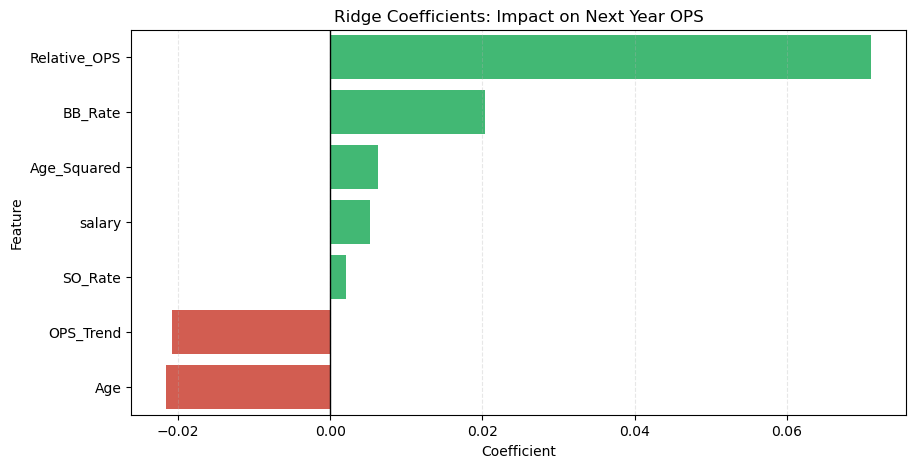


Model Interpretation:
- Relative_OPS has a positive impact.
- BB_Rate has a positive impact.
- Age_Squared has a positive impact.
- salary has a positive impact.
- SO_Rate has a positive impact.
- OPS_Trend has a negative impact.
- Age has a negative impact.


In [131]:
ridge_coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': ridge_model.coef_
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 5))
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in ridge_coef_df['Coefficient']]

sns.barplot(x='Coefficient', y='Feature', data=ridge_coef_df, hue='Feature', palette=colors, legend=False)

plt.axvline(0, color='black', lw=1)
plt.title('Ridge Coefficients: Impact on Next Year OPS')
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.show()

print("\nModel Interpretation:")
for index, row in ridge_coef_df.iterrows():
    direction = "positive" if row['Coefficient'] > 0 else "negative"
    print(f"- {row['Feature']} has a {direction} impact.")

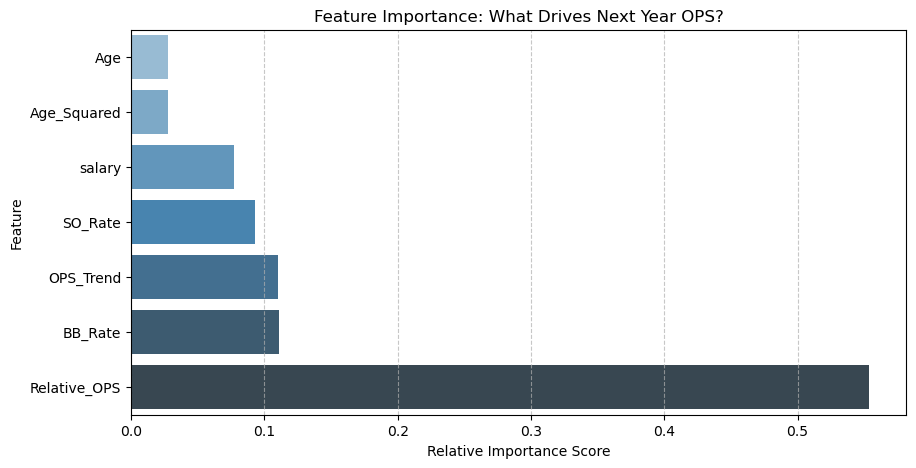

In [132]:
importances = rf_model.feature_importances_
feat_imp = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 5))

sns.barplot(x='Importance', y='Feature', data=feat_imp, hue='Feature', palette='Blues_d', legend=False)

plt.title('Feature Importance: What Drives Next Year OPS?')
plt.xlabel('Relative Importance Score')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

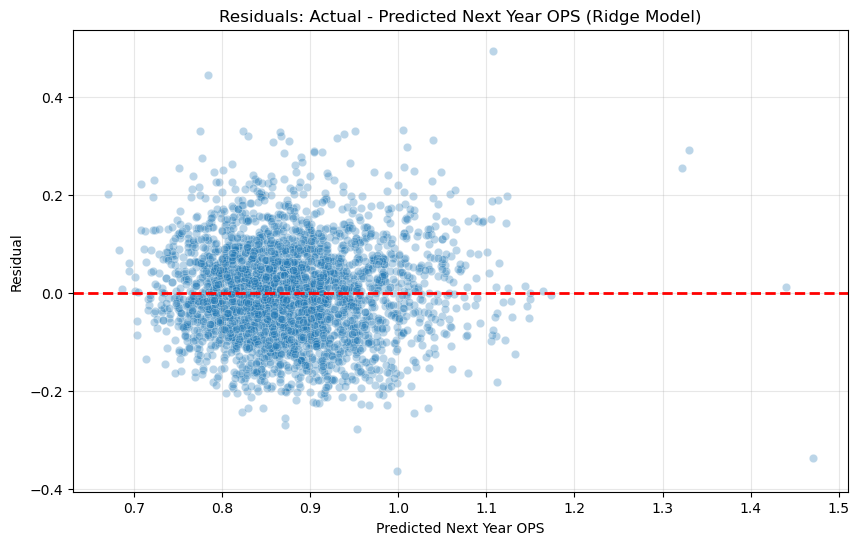

In [133]:
X_full_scaled = scaler.transform(X)
model_data['Predicted_Next_Year_OPS'] = ridge_model.predict(X_full_scaled)

model_data['Residual'] = model_data['Next_Year_OPS'] - model_data['Predicted_Next_Year_OPS']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Predicted_Next_Year_OPS', y='Residual', data=model_data, alpha=0.3)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title('Residuals: Actual - Predicted Next Year OPS (Ridge Model)')
plt.xlabel('Predicted Next Year OPS')
plt.ylabel('Residual')
plt.grid(True, alpha=0.3)
plt.show()

def analyze_underperformers(df, master, year):
    subset = df[df['yearID'] == year].copy()
    if subset.empty:
        print(f" No data found for year {year}")
        return
    underperformers = subset.sort_values('Residual').head(10)
    final_list = pd.merge(underperformers, master[['playerID', 'nameFirst', 'nameLast']], on='playerID')
    print(f"\n Top 10 Underperformers in {year+1} Based on {year} data:")
    display(final_list[['nameFirst', 'nameLast', 'yearID', 'Next_Year_OPS', 'Predicted_Next_Year_OPS', 'Residual']])

def analyze_overperformers(df, master, year):
    subset = df[df['yearID'] == year].copy()
    if subset.empty:
        print(f"No data found for year {year}")
        return
    overperformers = subset.sort_values('Residual', ascending=False).head(10)
    final_list = pd.merge(overperformers, master[['playerID', 'nameFirst', 'nameLast']], on='playerID')
    print(f"\n Top 10 Overperformers in {year+1} Based on {year} data:")
    display(final_list[['nameFirst', 'nameLast', 'yearID', 'Next_Year_OPS', 'Predicted_Next_Year_OPS', 'Residual']])



In [134]:
analyze_underperformers(model_data, master, 2014)


 Top 10 Underperformers in 2015 Based on 2014 data:


,nameFirst,nameLast,yearID,Next_Year_OPS,Predicted_Next_Year_OPS,Residual
0,Mike,Zunino,2014,0.59,0.83,-0.24
1,Victor,Martinez,2014,0.74,0.97,-0.23
2,Jayson,Werth,2014,0.77,0.98,-0.21
3,Billy,Hamilton,2014,0.60,0.80,-0.21
4,Adam,LaRoche,2014,0.71,0.92,-0.21
5,Hanley,Ramirez,2014,0.80,1.00,-0.20
6,J. J.,Hardy,2014,0.62,0.81,-0.19
7,Chris,Owings,2014,0.66,0.85,-0.19
8,Alexi,Amarista,2014,0.60,0.77,-0.17
9,Mike,Napoli,2014,0.79,0.96,-0.17


In [135]:
analyze_overperformers(model_data, master, 2014)


 Top 10 Overperformers in 2015 Based on 2014 data:


,nameFirst,nameLast,yearID,Next_Year_OPS,Predicted_Next_Year_OPS,Residual
0,Bryce,Harper,2014,1.26,0.94,0.33
1,Gerardo,Parra,2014,1.00,0.82,0.18
2,Mark,Teixeira,2014,1.04,0.89,0.15
3,David,Peralta,2014,1.01,0.87,0.14
4,Josh,Donaldson,2014,1.07,0.94,0.13
5,Nolan,Arenado,2014,1.04,0.91,0.13
6,Jonathan,Schoop,2014,0.89,0.77,0.12
7,Mike,Moustakas,2014,0.92,0.80,0.12
8,Nelson,Cruz,2014,1.05,0.93,0.12
9,Lorenzo,Cain,2014,0.94,0.83,0.11


In [136]:
df['OPS_Value_per_Million'] = df['Relative_OPS'] / (df['salary'] / 1_000_000)
df['At_Risk_Salary'] = np.where(df['OPS_Trend'] < -0.05, df['salary'], 0)

ceo_summary = df.groupby('yearID').agg({
    'salary': 'sum',
    'At_Risk_Salary': 'sum',
    'Relative_OPS': 'mean'
}).reset_index()

ceo_summary['Risk_Ratio'] = (ceo_summary['At_Risk_Salary'] / ceo_summary['salary']) * 100

pd.options.display.float_format = '{:,.2f}'.format

display_summary = ceo_summary.copy()
display_summary['salary'] = display_summary['salary'] / 1_000_000
display_summary['At_Risk_Salary'] = display_summary['At_Risk_Salary'] / 1_000_000

display_summary.columns = ['Year', 'Total Salary ($M)', 'At-Risk Salary ($M)', 'Avg Relative OPS', 'Risk Ratio (%)']

print("---BENCHMARKING: QUANTITATIVE FINANCIAL EXPOSURE & CONTRACT VALUATION FOR HITTERS ONLY THE ENTIRE LEAGUE---")
display(ceo_summary.tail(5))

---BENCHMARKING: QUANTITATIVE FINANCIAL EXPOSURE & CONTRACT VALUATION FOR HITTERS ONLY THE ENTIRE LEAGUE---


,yearID,salary,At_Risk_Salary,Relative_OPS,Risk_Ratio
11,2010,"984,741,075.00","503,216,259.00",0.06,51.10
12,2011,"1,002,830,825.00","375,691,345.00",0.06,37.46
13,2012,"1,054,935,689.00","383,438,924.00",0.06,36.35
14,2013,"1,089,679,989.00","415,125,631.00",0.06,38.10
15,2014,"1,019,375,789.00","450,432,446.00",0.06,44.19


In [137]:
target_team = 'PHI' 

team_data = df[df['teamID'] == target_team].copy()

team_summary = team_data.groupby('yearID').agg({
    'salary': 'sum',
    'At_Risk_Salary': 'sum',
    'Relative_OPS': 'mean'
}).reset_index()

team_summary['Risk_Ratio'] = (team_summary['At_Risk_Salary'] / team_summary['salary']) * 100

print(f"--- CEO STRATEGIC REPORT: {target_team} PAYROLL HEALTH ---")
display(team_summary.tail(5))

--- CEO STRATEGIC REPORT: PHI PAYROLL HEALTH ---


,yearID,salary,At_Risk_Salary,Relative_OPS,Risk_Ratio
11,2010,"74,519,046.00","59,952,380.00",0.09,80.45
12,2011,"71,619,046.00","35,619,046.00",0.04,49.73
13,2012,"57,597,380.00","19,900,000.00",0.03,34.55
14,2013,"32,300,714.00","16,000,000.00",0.02,49.53
15,2014,"46,450,000.00","33,000,000.00",0.00,71.04


In [138]:
model_data['Efficiency_Score'] = model_data['Relative_OPS'] / (model_data['salary'] / 1_000_000)

latest_year = model_data['yearID'].max()
current_market = model_data[model_data['yearID'] == latest_year].copy()

current_market = pd.merge(current_market, master[['playerID', 'nameFirst', 'nameLast']], on='playerID')

strategic_buys = current_market.sort_values(by='Efficiency_Score', ascending=False).head(10)

toxic_assets = current_market[current_market['salary'] >= 5_000_000].sort_values(by='Efficiency_Score', ascending=True).head(10)

pd.options.display.float_format = '{:,.2f}'.format

print(f"--- CEO STRATEGIC REPORT: MARKET ARBITRAGE ({latest_year}) ---")
print("\nTOP 10 'GROWTH' ASSETS (High Efficiency Targets):")
display(strategic_buys[['nameFirst', 'nameLast', 'salary', 'Relative_OPS', 'Efficiency_Score']])

print("\nTOP 10 'High-Exposure Liabilities' ASSETS (High-Cost / Low-Alpha Risk):")
display(toxic_assets[['nameFirst', 'nameLast', 'salary', 'Relative_OPS', 'Efficiency_Score']])

--- CEO STRATEGIC REPORT: MARKET ARBITRAGE (2014) ---

TOP 10 'GROWTH' ASSETS (High Efficiency Targets):


,nameFirst,nameLast,salary,Relative_OPS,Efficiency_Score
6,Nolan,Arenado,"500,000.00",0.17,0.35
72,Josh,Harrison,"513,000.00",0.17,0.33
152,Mike,Trout,"1,000,000.00",0.30,0.30
61,Paul,Goldschmidt,"1,100,000.00",0.30,0.28
59,Evan,Gattis,"520,250.00",0.14,0.27
27,Chris,Carter,"510,000.00",0.14,0.27
97,Starling,Marte,"500,000.00",0.13,0.25
41,Josh,Donaldson,"500,000.00",0.12,0.24
139,Anthony,Rizzo,"1,250,000.00",0.25,0.20
24,Kole,Calhoun,"506,000.00",0.10,0.20



TOP 10 'High-Exposure Liabilities' ASSETS (High-Cost / Low-Alpha Risk):


,nameFirst,nameLast,salary,Relative_OPS,Efficiency_Score
81,Omar,Infante,"5,000,000.00",-0.09,-0.02
49,Yunel,Escobar,"5,000,000.00",-0.06,-0.01
4,Elvis,Andrus,"6,475,000.00",-0.07,-0.01
148,Ichiro,Suzuki,"6,500,000.00",-0.07,-0.01
17,Jay,Bruce,"10,000,000.00",-0.04,-0.00
75,Aaron,Hill,"11,000,000.00",-0.05,-0.00
70,J. J.,Hardy,"7,000,000.00",-0.03,-0.00
125,Brandon,Phillips,"11,000,000.00",-0.03,-0.00
128,Martin,Prado,"11,000,000.00",-0.03,-0.00
8,Erick,Aybar,"8,500,000.00",-0.01,-0.00


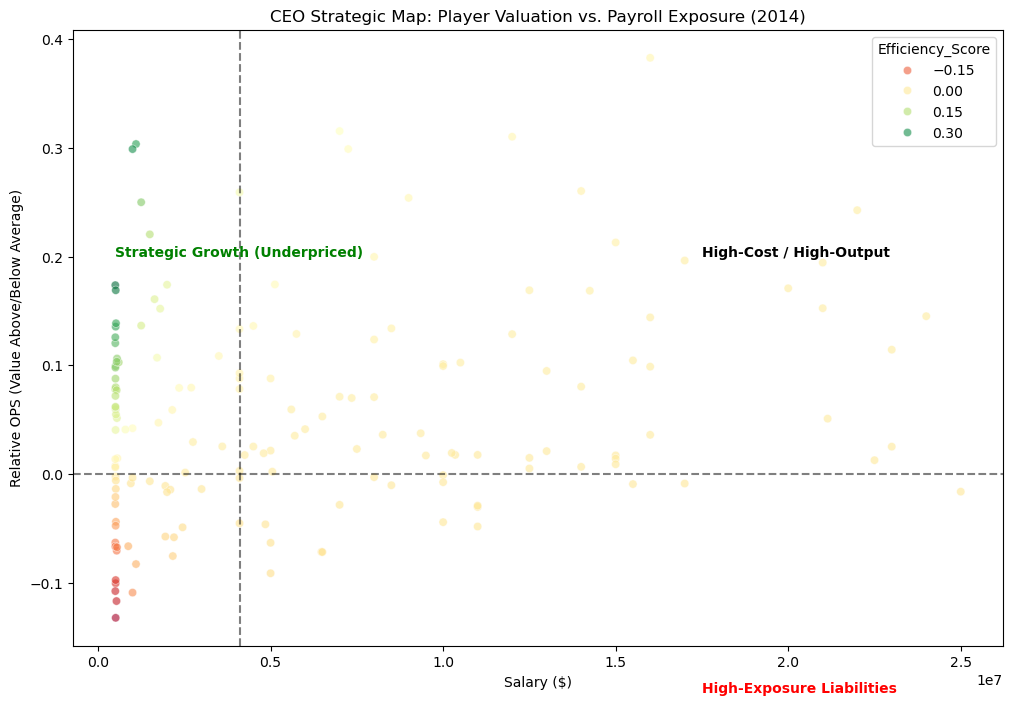

In [139]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=current_market, x='salary', y='Relative_OPS', alpha=0.6, hue='Efficiency_Score', palette='RdYlGn')

plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.axvline(current_market['salary'].median(), color='black', linestyle='--', alpha=0.5)

plt.text(current_market['salary'].max()*0.7, 0.2, "High-Cost / High-Output", fontsize=10, weight='bold')
plt.text(current_market['salary'].min(), 0.2, "Strategic Growth (Underpriced)", fontsize=10, weight='bold', color='green')
plt.text(current_market['salary'].max()*0.7, -0.2, "High-Exposure Liabilities", fontsize=10, weight='bold', color='red')

plt.title(f'CEO Strategic Map: Player Valuation vs. Payroll Exposure ({latest_year})')
plt.xlabel('Salary ($)')
plt.ylabel('Relative OPS (Value Above/Below Average)')
plt.show()

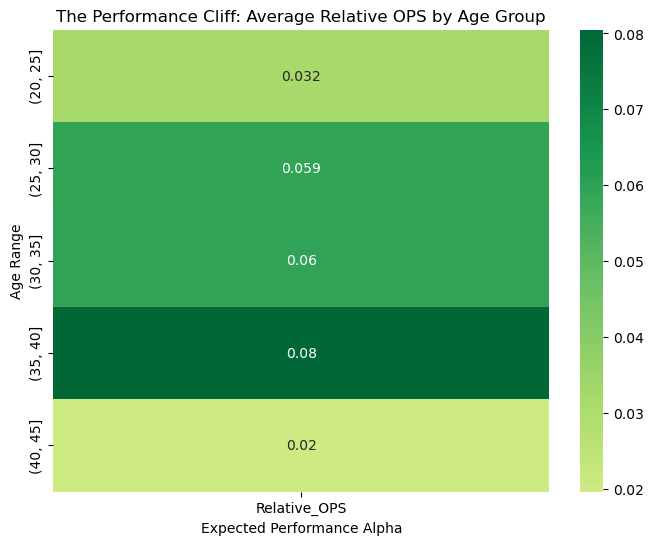

In [140]:
model_data['Age_Bin'] = pd.cut(model_data['Age'], bins=[20, 25, 30, 35, 40, 45])
pivot_table = model_data.pivot_table(values='Relative_OPS', index='Age_Bin', aggfunc='mean', observed=False)
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap='RdYlGn', center=0)
plt.title('The Performance Cliff: Average Relative OPS by Age Group')
plt.ylabel('Age Range')
plt.xlabel('Expected Performance Alpha')
plt.show()